# Proyecto Mineria de Datos

El DataSet suministrado contiene datos relacionados con campañas de marketing de una institución bancaria portuguesa, los diferentes atributos que se presentan son edad, trabajo, nivel de educación, estado civil, entre otros. Los cuales ayudaran a predecir la clase la cual corresponde a **SI** el cliente suscribira o **NO** un deposito a plazo bancario.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import random
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import wittgenstein as lw
from sklearn.metrics import precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from ipywidgets import interact, interactive,fixed,interact_manual
import ipywidgets as widgets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


In [2]:
datos1= pd.read_excel ('bank-full.xlsx')
datos1.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Consultamos la dimension del DataSet

In [3]:
datos1.shape

(45211, 17)

Al conocer la gran dimensionalidad del DataSet se decidio seguir trabajando con este, pero mas adelante cuando se realizaban todos los analisis se presentaron altos tiempos de procesamiento de la maquina, lo cual se convirtio en un gran problema. De la fuente donde se tomo el DataSet tambien habia uno mas pequeño que correspondia al 10% del DataSet principal, por ende se decidio trabajar con este segundo conjunto de datos.

In [4]:
datos2= pd.read_excel ('bank.xlsx')

Se consulta su dimension

In [5]:
datos2.shape

(4521, 17)

In [6]:
datos2.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Debido a que se tomo el 10% del DataSet principal es importante ver que cantidad de cada clase hay, si hay un gran desbalance entre los valores que puede tomar la clase, **NO** es viable para futuros analisis ya que se estaria sesgando el conjunto de datos real que se obtuvo desde el comienzo. A continuación se muestra el diagrama de barras y su resprectiva tabla donde se muestra como se comporta la clase.

<AxesSubplot:ylabel='y'>

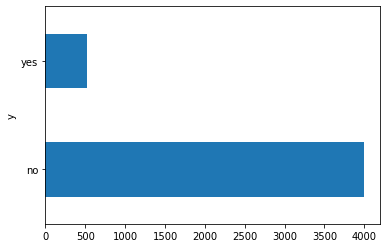

In [7]:
datos2.groupby('y')['y'].count().plot(kind='barh')

In [8]:
datos2.groupby(['y']).size().reset_index(name='Cantidad')

,y,Cantidad
0,no,4000
1,yes,521


Como se muestra en la tabla anterior, hay 4000 registros de clases negativa (no), y 521 de la clase positiva (si), es evidente el desbalance que se presenta, por lo cual como se menciono anteriormente, al construir un modelo con este DataSet, se estarian sesgando los datos suministrados desde un comienzo, lo cual generaria un modelo erroneo alejado de la realidad. 

Por esta razon es que se decidio volver al DataSet principal y tomar el 5% de registros con clases negativas y el 5% de registros con clases positivas, de esta manera se obtiene el 10% del DataSet principal y se tiene un balance en las clases, para asi lograr construir modelos confiables que se asemejen a la realidad.

In [9]:
datosN = datos1.copy()
datosN = datosN.drop(datosN[datosN['y']=='yes'].index)
datosP = datos1.copy()
datosP = datosP.drop(datosP[datosP['y']=='no'].index) 

En las anteriores lineas de codigo se separo el DataSet principal en dos DataSet mas pequeños; uno contiene los registros unicamente con clase positiva (si) y el otro los registros con clase negativa (no), esto con el fin de facilitar la seleccion aleatoria del 5% de cada clase respecto al DataSet principal. 

A continuación se realiza dicha seleccion del 5% de cada clase y se juntan estos dos conjuntos de datos en un nuevo DataSet llamado ***datos***, siendo este el que se estudiara en todo el cuadernillo.

In [10]:
DatosN = datosN.sample(2261, random_state=1)
DatosP = datosP.sample(2261, random_state=1)

In [11]:
datos = pd.concat([DatosN, DatosP],ignore_index=True)

Se procede a verificar que el nuevo DataSet a trabajar tenga la clase balanceada.

<AxesSubplot:ylabel='y'>

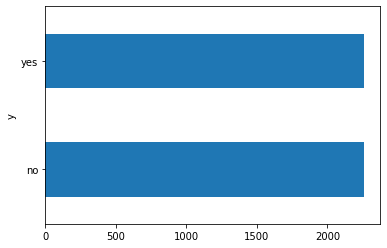

In [12]:
datos.groupby('y')['y'].count().plot(kind='barh')

In [13]:
datos.groupby(['y']).size().reset_index(name='Cantidad')

,y,Cantidad
0,no,2261
1,yes,2261


Segun el diagrama de barras anterior y su tabla, efectivamente el nuevo DataSet llamado ***datos*** tiene balanceada la clase, por ende, ya se puede trabajar con este sin sesgar datos. Se decidió que la cantidad de registros con clase ***No*** fuera igual a la cantidad de registros con clase ***yes*** ya que en uno de los artículos cientificos consultados para realiza este proyecto, trataban el problema de desbalance de esta manera.

#### 1. Datos Faltantes
Procedemos a calcular valores faltantes dentro del DataSet.

In [14]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4522 entries, 0 to 4521
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
 16  y          4522 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.7+ KB


In [15]:
datos.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [16]:
datos.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

#### 2. Exploratory Data Analysis.

A continuación se mostraran graficas EDA para la exploración de las diferentes variables del DataSet suministrado. El fin de dicha exploración es ver el comportamiento de cada atributo, identificar datos atipicos, faltantes y atributos que no generan valor o redundates que se deben eliminar.

#### - Age

Text(0.5, 0, 'Datos de edad Agrupados')

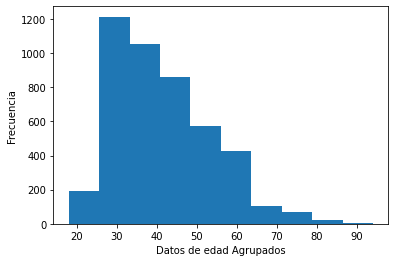

In [17]:
plt.hist(datos['age'])
plt.ylabel('Frecuencia')
plt.xlabel('Datos de edad Agrupados')

El anterior diagrama de frecuencia muestra que la mayoria de las personas que se contactaron tienen entre 25 y 33 años.

#### - Job

En la siguiente grafica se observa el numero de personas segun su tipo de trabajo.

<AxesSubplot:ylabel='job'>

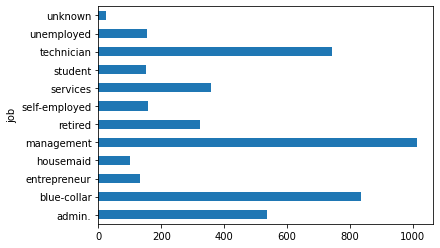

In [18]:
datos.groupby('job')['job'].count().plot(kind='barh')

Segun la grafica anterior se puede concluir que la mayoria de personas de los datos suministrados trabajan como management, luego van las personas de  cuello azul lo cual se entiende que trabajan como operarios y despues le siguen las personas que trabajan como tecnicos. En la siguiente tabla se muestra la cantidad exacta de las personas segun su tipo de trabajo.

In [19]:
datos.groupby(['job']).size().reset_index(name='Cantidad')

,job,Cantidad
0,admin.,535
1,blue-collar,834
2,entrepreneur,131
3,housemaid,99
4,management,1014
5,retired,323
6,self-employed,156
7,services,358
8,student,151
9,technician,744


Al realizar la grafica y su respectiva tabla, tambien nos damos cuenta que hay un registro que se llama "unknown" el cual se traduce como desconocido, este registro da a entender que para algunas personas **se desconoce** que tipo de trabajo tienen, en principio se podria pensar que estos son datos faltantes, sin embargo se tomarán como una categoria más del atributo job, ya que puede suceder que existan personas que no quieran dar información acerca de su trabajo y esto podria tener relación en si aceptan o no un deposito a termino

A continuación se presenta un gráfico dinámico que muestra el porcentaje de personas que estarian dispuestos o no a invertir en un deposito a término fijo según su tipo de trabajo, se observa que las personas cuyo trabajo es:***unknown,unemployed,management,student,self-employed y retired*** son más propensas a adquirir un dopisto a termino fijo ya que para este tipo de trabajos, el porcentaje de registros en donde la clase es ***yes*** es mayor al porcentaje de registros cuya clase es ***no***

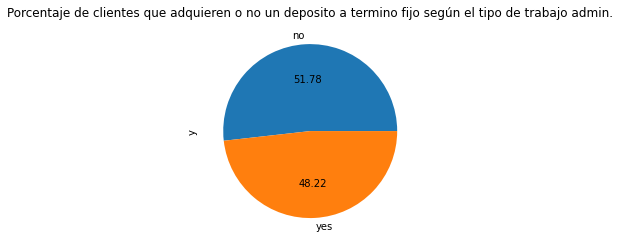

interactive(children=(Dropdown(description='Trabajo', options=('admin.', 'unknown', 'unemployed', 'management'…

<function __main__.gj(Trabajo)>

In [20]:
job=["admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services"] 
def gj(Trabajo):
    datos[datos['job']==Trabajo].groupby('y')['y'].count().plot(kind='pie',autopct='%.2f',title='Porcentaje de clientes que adquieren o no un deposito a termino fijo según el tipo de trabajo '+Trabajo)
interact(gj,Trabajo=job)

#### - Marital

<AxesSubplot:ylabel='marital'>

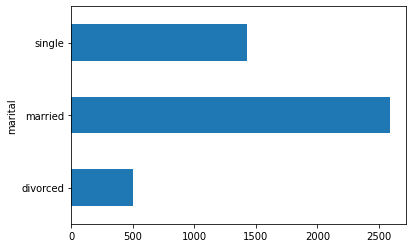

In [21]:
datos.groupby('marital')['marital'].count().plot(kind='barh')

In [22]:
datos.groupby(['marital']).size().reset_index(name='Cantidad')

,marital,Cantidad
0,divorced,504
1,married,2590
2,single,1428


Como se muestra en la grafica anterior y en su respectiva tabla, la mayoria de personas son casadas y luego siguen las personas solteras.

A continuación se presenta un gráfico dinámico en donde se observa el porcentaje de clientes que invirtieron o no en un deposito a término fijo según su estado civil. Se observa que es más probable que las personas cuyo estado civil sea **divorced o single** inviertan en un deposito a término fijo ya que  el porcentaje de registros cuya clase es **yes** es mayor al porcentaje de registros cuya clase es **no**

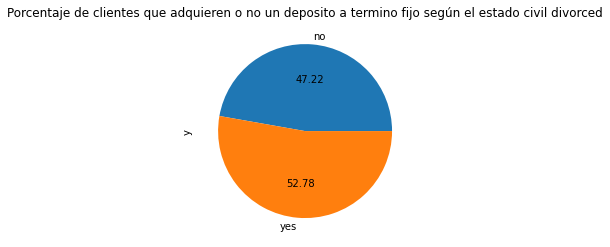

interactive(children=(Dropdown(description='ecivil', options=('divorced', 'married', 'single'), value='divorce…

<function __main__.gm(ecivil)>

In [23]:
marital=['divorced','married','single']
def gm(ecivil):
    datos[datos['marital']==ecivil].groupby('y')['y'].count().plot(kind='pie',autopct='%.2f',title='Porcentaje de clientes que adquieren o no un deposito a termino fijo según el estado civil '+ecivil)
interact(gm,ecivil=marital)


#### - Education

<AxesSubplot:ylabel='education'>

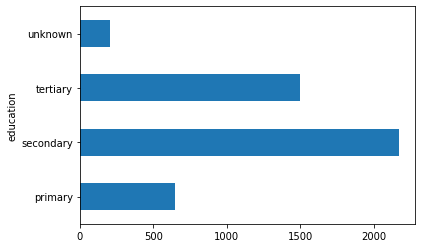

In [24]:
datos.groupby('education')['education'].count().plot(kind='barh')

In [25]:
datos.groupby(['education']).size().reset_index(name='Cantidad')

,education,Cantidad
0,primary,647
1,secondary,2171
2,tertiary,1497
3,unknown,207


Como se muestra en la grafica anterior y en su respectiva tabla, el nivel de educación que más se presenta en el DataSet es secundaria y luego terciaria, la cual corresponde a universidades o colegios profesionales. Al igual que el atributo Job, aparece un registro llamado 'unknow' y tambien se tomara como una categoria del atributo.

Del siguiente gráfico dinámico se observa que las personas cuya educación sea desconocida o terciaria son más propensas a adquirir un deposito a término fijo, porque el porcentaje de registros en donde la clase es **yes** es mayor al porcentaje de registros cuya clase es **no**

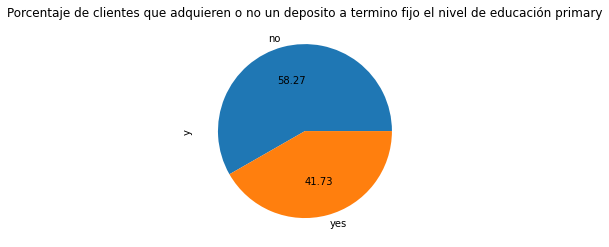

interactive(children=(Dropdown(description='Educacion', options=('primary', 'secondary', 'tertiary', 'unknown'…

<function __main__.ge(Educacion)>

In [26]:
education=['primary','secondary','tertiary','unknown']
def ge(Educacion):
    datos[datos['education']==Educacion].groupby('y')['y'].count().plot(kind='pie',autopct='%.2f',title='Porcentaje de clientes que adquieren o no un deposito a termino fijo el nivel de educación '+Educacion)
interact(ge,Educacion=education)

#### - Default

<AxesSubplot:xlabel='default'>

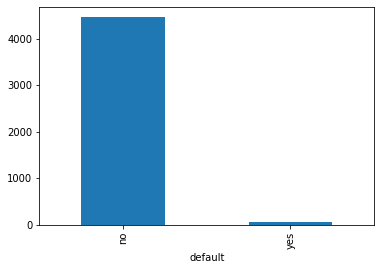

In [27]:
datos.groupby('default')['default'].count().plot(kind='bar')

In [28]:
datos.groupby(['default']).size().reset_index(name='Cantidad')

,default,Cantidad
0,no,4461
1,yes,61


Este atributo responde a la pregunta ¿Tiene credito en mora?, lo cual como se ve en la grafica anterior y en la tabla; hay 4461 personas que no tienen credito en mora y 61 que si.

#### - Balance 

<AxesSubplot:ylabel='balance'>

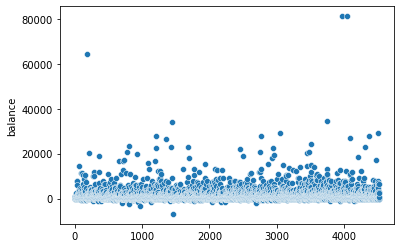

In [29]:
sns.scatterplot(x=datos.index, y=datos['balance'])

En el grafico anterior se muestra la dispersión del saldo medio anual en euros de cada persona del DataSet. Como se puede observar tiene alta variabilidad ya que pues son muchos registros y no se tiene cierto comportamiento.

#### - Housing 

<AxesSubplot:xlabel='housing'>

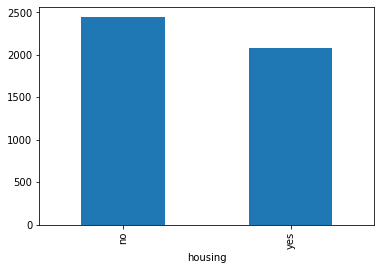

In [30]:
datos.groupby('housing')['housing'].count().plot(kind='bar')

In [31]:
datos.groupby(['housing']).size().reset_index(name='Cantidad')

,housing,Cantidad
0,no,2441
1,yes,2081


Este atributo responde a la pregunta ¿tiene prestamo para vivienda? y segun el grafico y su tabla correspondiente hay 2441 personas que no tienen y 2081 que si.

#### - Loan

<AxesSubplot:xlabel='loan'>

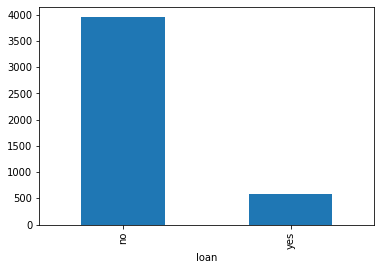

In [32]:
datos.groupby('loan')['loan'].count().plot(kind='bar')

In [33]:
datos.groupby(['loan']).size().reset_index(name='Cantidad')

,loan,Cantidad
0,no,3948
1,yes,574


Este atributo responde a la pregunta ¿Tiene prestamo personal?, segun el diagrama y su tabla correspondiente; hay 3948 personas que no tienen prestamo personal y 574 que si.

#### - Contact

Text(0, 0.5, '')

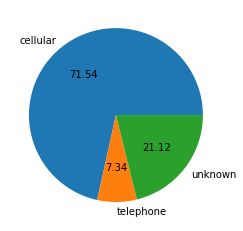

In [34]:
datos.groupby('contact')['contact'].count().plot(kind='pie',autopct='%.2f')
plt.ylabel('')

Este atributo corresponde al medio por el cual se pueden contactar las personas, segun el diagrama de torta ilustrado anteriormente; el 71.54% de las personas se pueden contactar por medio del celular movil, el 7,34% por el telefono y se desconoce el 21,12% restante.  

Se considera que este atributo no genera valor al momento de realizar la prediccion de la clase, por ende **se eliminará.**

#### - Day

Este atributo llamado 'Dia' toma valores ente 1 y 31, y corresponde al ultimo dia que hubo contacto con cada persona. Lo cual no nos parece que el atributo genere gran valor al momento de predecir la clase. Esta decision tambien se tomo debido a que en papers donde se desarrollaba el mismo DataSet se decia lo mismo acerca de este atributo. Por tal motivo se decide **eliminar.**

#### - Month

Esta variable muestra el ultimo mes que hubo contacto con cada persona, por lo cual se desea saber en que mes se generaron mas llamadas.

<AxesSubplot:ylabel='month'>

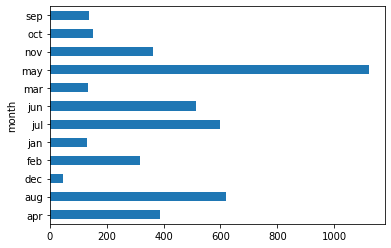

In [35]:
datos.groupby('month')['month'].count().plot(kind='barh')

In [36]:
datos.groupby(['month']).size().reset_index(name='Cantidad')

,month,Cantidad
0,apr,388
1,aug,619
2,dec,47
3,feb,318
4,jan,132
5,jul,598
6,jun,514
7,mar,133
8,may,1121
9,nov,362


En el mes de mayo se generaron la mayoria de contactos, exactamente fueron 1121, y luego sigue el mes de agosto con 619 llamadas.

Del siguiente gráfico se observa que las personas que fueron contactadas por última vez en los meses de ***abril, febrero,enero,octubre,septiembre,marzo y diciembre*** son más propensas a adquirir un deposito a término fijo, ya que el porcentaje de registros donde la clase fue **yes** es mayor al porcentaje de registros donde la clase fue **no**.

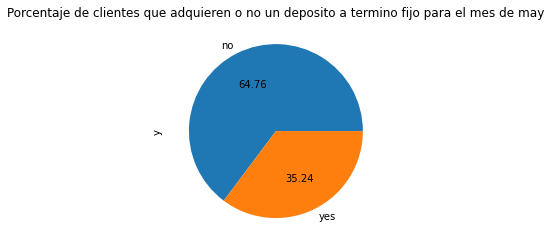

interactive(children=(Dropdown(description='mes', options=('may', 'jul', 'aug', 'jun', 'nov', 'apr', 'feb', 'j…

<function __main__.g(mes)>

In [37]:
meses=['may','jul','aug','jun','nov','apr','feb','jan','oct','sep','mar','dec']
def g(mes):
    datos[datos['month']==mes].groupby('y')['y'].count().plot(kind='pie',autopct='%.2f',title='Porcentaje de clientes que adquieren o no un deposito a termino fijo para el mes de '+mes)
interact(g,mes=meses)

#### - Duration

Este atributo contiene valores numericos los cuales corresponden a la duracion de la ultima llamada en segundos. Y como se muestra a continuación hay alta variabilidad en los registros.

<AxesSubplot:ylabel='duration'>

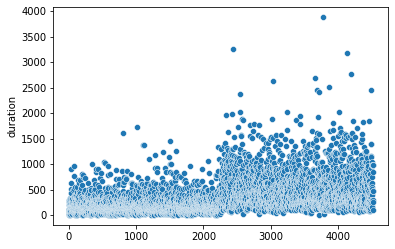

In [38]:
sns.scatterplot(x=datos.index, y=datos['duration'])

In [39]:
datos['duration'].min()

3

In [40]:
datos['duration'].max()

3881

La llamada mas corta es de 3 segundos y la mas larga es de 3881 segundos. Sin embargo, se decide **eliminar** este atributo ya que en la fuente donde se tomo este data set se sugiere no tenerlo encuenta si se desea obtener un modelo predictivo real, lo cual es bastante logico porque la duración de la llamada solamente es conocida cuando se lleva a cabo la ultima llamada donde se conoce si el cliente decide o no invertir en un deposito a termino fijo.

#### - Campaign

Este atributo me dice el numero de contactos realizados durante la campaña con cada persona.

In [41]:
datos['campaign'].mean()

2.5061919504643964

En promedio se realizaron 3 llamadas durante la campaña para cada cliente. A continuación se muestra su histograma de barras lo cual muestra que la mayoria de las personas se llamaron entre 1 y 5 veces durante la campaña.

Text(0.5, 0, 'Numero de llamadas agrupadas')

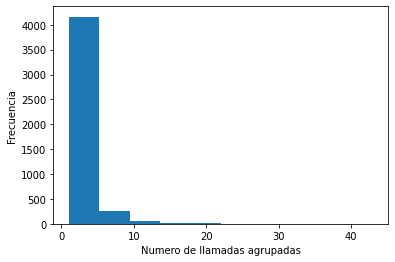

In [42]:
plt.hist(datos['campaign'])
plt.ylabel('Frecuencia')
plt.xlabel('Numero de llamadas agrupadas')

#### - Pdays

Numero de dias que pasaron despues de que el cliente fue contactado por ultima vez desde una campaña anterior. En el siguiente histograma de frecuencia se puede evidenciar que pasaron entre 0 y 100 dias desde la ultima vez, para ponerse en contacto con la mayoria de clientes. De igual manera se muestra el grafico de dispersion donde se evidencia un comportamiento aleatorio pero se ve que la mayoria de datos se concentran en un intervalo de 0 a 100.

Text(0.5, 0.98, 'Histograma de frecuencia y grafico de dispersion')

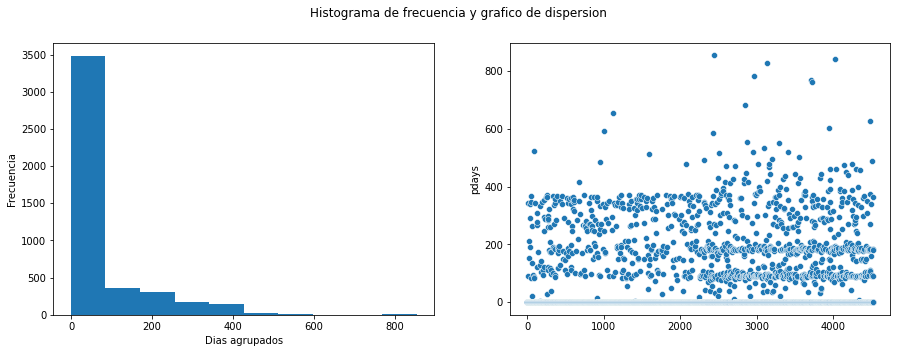

In [43]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(datos['pdays'])
plt.ylabel('Frecuencia')
plt.xlabel('Dias agrupados')
plt.subplot(1,2,2)
sns.scatterplot(x=datos.index, y=datos['pdays'])
plt.suptitle('Histograma de frecuencia y grafico de dispersion')

#### - Previous

Atributo que muestra el número de llamadas realizadas antes de la campaña. 

En el siguiente histograma de frecuencia se evidencia que la mayoria de las personas fueron llamadas de 1 a 5 veces antes de la presente campaña, de igual manera se evidencia en el grafico de dispersion que la mayoria de los datos se concentran en un rango de 1 a 5.

Text(0.5, 0.98, 'Histograma de frecuencia y grafico de dispersion')

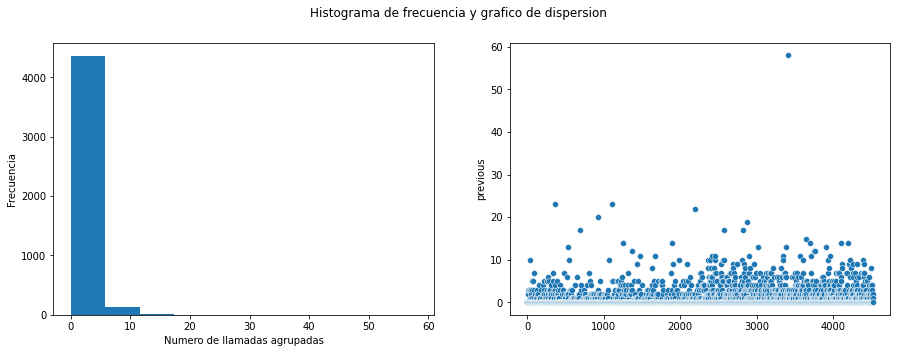

In [44]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(datos['previous'])
plt.ylabel('Frecuencia')
plt.xlabel('Numero de llamadas agrupadas')
plt.subplot(1,2,2)
sns.scatterplot(x=datos.index, y=datos['previous'])
plt.suptitle('Histograma de frecuencia y grafico de dispersion')

#### - Outcome

Este atributo o variable muestra el resultado de la campaña de marketing anterior es decir, si funciono o fracaso.

<AxesSubplot:ylabel='poutcome'>

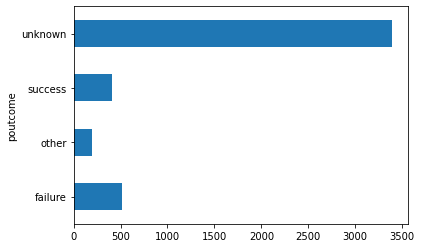

In [45]:
datos.groupby('poutcome')['poutcome'].count().plot(kind='barh')

In [46]:
datos.groupby(['poutcome']).size().reset_index(name='Cantidad')

,poutcome,Cantidad
0,failure,516
1,other,199
2,success,411
3,unknown,3396


Segun la grafica anterior y su respectiva tabla, la campaña fue exitosa 411 veces y NO exitosa 516 veces. De las demas personas el estado de la campaña se desconoce.

Se observa que si el resultado de la última campaña realizada para una persona fue ***failure, other o success*** es probale que la personas adquiera un deposito a término fijo en esta nueva campaña, sin embargo, si la anterior campaña fue ***success*** es mucho más probable que esa persona adquiera un deposito a término fijo porque el porcentaje de registros donde la clase fue **yes** es 91.97%.

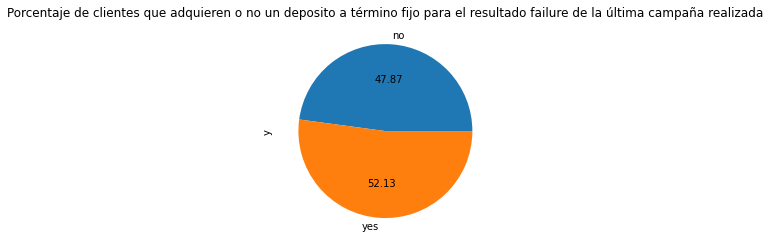

interactive(children=(Dropdown(description='Resultado', options=('failure', 'other', 'success', 'unknown'), va…

<function __main__.go(Resultado)>

In [47]:
poutcome=['failure','other','success','unknown']
def go(Resultado):
    datos[datos['poutcome']==Resultado].groupby('y')['y'].count().plot(kind='pie',autopct='%.2f',title='Porcentaje de clientes que adquieren o no un deposito a término fijo para el resultado '+Resultado+' de la última campaña realizada')
interact(go,Resultado=poutcome)

A continuación se eliminarán los atributos **Day**, **Contact** y **Duration** porque NO generán valor para determinar si una persona suscribiria o no, un deposito a plazo bancario.

In [48]:
datos=datos.drop(["day","contact","duration"],axis=1)

#### Segun el analisis EDA realizado y la consulta de datos faltantes al comienzo de cuadernillo, se puede concluir que el DataSet NO contiene valores faltantes, por lo cual se van a insertar un 10% de datos faltantes aleatoreamente.

In [49]:
y=datos.copy()
y=y.drop(["y"],axis=1)
np.random.seed(0)
y = y.mask(np.random.random(y.shape) < 0.1059)
clase=datos["y"]
df=y.copy()
df.insert(13,"y",clase)
falt= df.isnull().sum().sum()
print(falt/(datos.shape[0]*datos.shape[1]) * 100)
print(falt)

10.031907499842042
6351


Anteriormente se muestra el porcentaje de faltantes introducido (10%) que corresponde a **6351 datos faltantes.**

#### 3. PreProcesamiento

Teniendo en cuenta que ahora el data set tiene datos faltantes, es necesario realizar imputación, se consideran diferentes métodos: imputación por la media, imputación por la mediana, imputación por la moda, imputación por KNN con K=3, K=10 y K=15. El criterio de decisión para escoger el mejor método será el menor MSE. Debido a que KNN trabaja con distancias, es necesario realizar un proceso de discretización previamente en los atributos categoricos.

#### Discretización

Durante esta etapa, se cambiarán los datos categoricos por numericos. para futuros analisis es necesarios devolvernos de numericos a categoricos, por ende, para cada atributo categorico se genera una diccionario en donde las llaves de este son los valores categoricos que toma el atributo y los valores del diccionario serán los numeros asignados por el labelEncoder.

In [50]:
le=LabelEncoder()
Ndf=df.copy()

In [51]:
## Atributo job
Ndf['job']=le.fit_transform(Ndf['job'])
keys=le.classes_
values=le.transform(le.classes_)
djob=dict(zip(keys,values))
##Atributo marital
Ndf['marital']=le.fit_transform(Ndf['marital'])
keys=le.classes_
values=le.transform(le.classes_)
dmarital=dict(zip(keys,values))
##education
Ndf['education']=le.fit_transform(Ndf['education'])
keys=le.classes_
values=le.transform(le.classes_)
deducation=dict(zip(keys,values))
##poutcome
Ndf['poutcome']=le.fit_transform(Ndf['poutcome'])
keys=le.classes_
values=le.transform(le.classes_)
dpoutcome=dict(zip(keys,values))
##month
Ndf['month']=le.fit_transform(Ndf['month'])
keys=le.classes_
values=le.transform(le.classes_)
dmonth=dict(zip(keys,values))
##default
Ndf['default']=Ndf['default'].replace('yes',1)
Ndf['default']=Ndf['default'].replace('no',0)
##housing
Ndf['housing']=Ndf['housing'].replace('yes',1)
Ndf['housing']=Ndf['housing'].replace('no',0)
##loan
Ndf['loan']=Ndf['loan'].replace('yes',1)
Ndf['loan']=Ndf['loan'].replace('no',0)
##y
Ndf['y']=Ndf['y'].replace('yes',1)
Ndf['y']=Ndf['y'].replace('no',0)



A continuación se presentan los diccionarios generados: 

In [52]:
categorical=['job','marital','education','month','poutcome']

In [53]:
print("Dicccionario  para el atributo job:")
print(djob)
print("Diccionario para el atributo marital:")
print(dmarital)
print("Diccionario para el atributo education:")
print(deducation)
print("Diccionario para el atributo month:")
print(dmonth)
print("Diccionario para el atributo poutcome:")
print(dpoutcome)

Dicccionario  para el atributo job:
{'admin.': 0, 'blue-collar': 1, 'entrepreneur': 2, 'housemaid': 3, 'management': 4, 'retired': 5, 'self-employed': 6, 'services': 7, 'student': 8, 'technician': 9, 'unemployed': 10, 'unknown': 11, nan: 12}
Diccionario para el atributo marital:
{'divorced': 0, 'married': 1, 'single': 2, nan: 3}
Diccionario para el atributo education:
{'primary': 0, 'secondary': 1, 'tertiary': 2, 'unknown': 3, nan: 4}
Diccionario para el atributo month:
{'apr': 0, 'aug': 1, 'dec': 2, 'feb': 3, 'jan': 4, 'jul': 5, 'jun': 6, 'mar': 7, 'may': 8, 'nov': 9, 'oct': 10, 'sep': 11, nan: 12}
Diccionario para el atributo poutcome:
{'failure': 0, 'other': 1, 'success': 2, 'unknown': 3, nan: 4}


Se observa que el Label Encoder ha generado un numero para cada dato faltante, esto no nos funciona para realizar la imputación, por ende se cambiara el respectivo numero asginado por nan:

In [54]:
Ndf['job']=Ndf['job'].replace(12,np.nan)
Ndf['marital']=Ndf['marital'].replace(3,np.nan)
Ndf['education']=Ndf['education'].replace(4,np.nan)
Ndf['month']=Ndf['month'].replace(12,np.nan)
Ndf['poutcome']=Ndf['poutcome'].replace(4,np.nan)

Al momento de realizar las imputaciones por los diferentes metodos y evaluarlos mediante el error cuadratico medio (MSE) este daba valores muy grandes, lo cual NO es conveniente. La principal razon por la cual el error daba tan alto es la variabilidad que se encontro en algunos atributos en la primera fase de exploración de los datos (EDA), por esta razon a continuación se decidio mostrar graficos de dispersion de cada atributo, con el fin de observar la alta variabilidad de TODAS las variables.

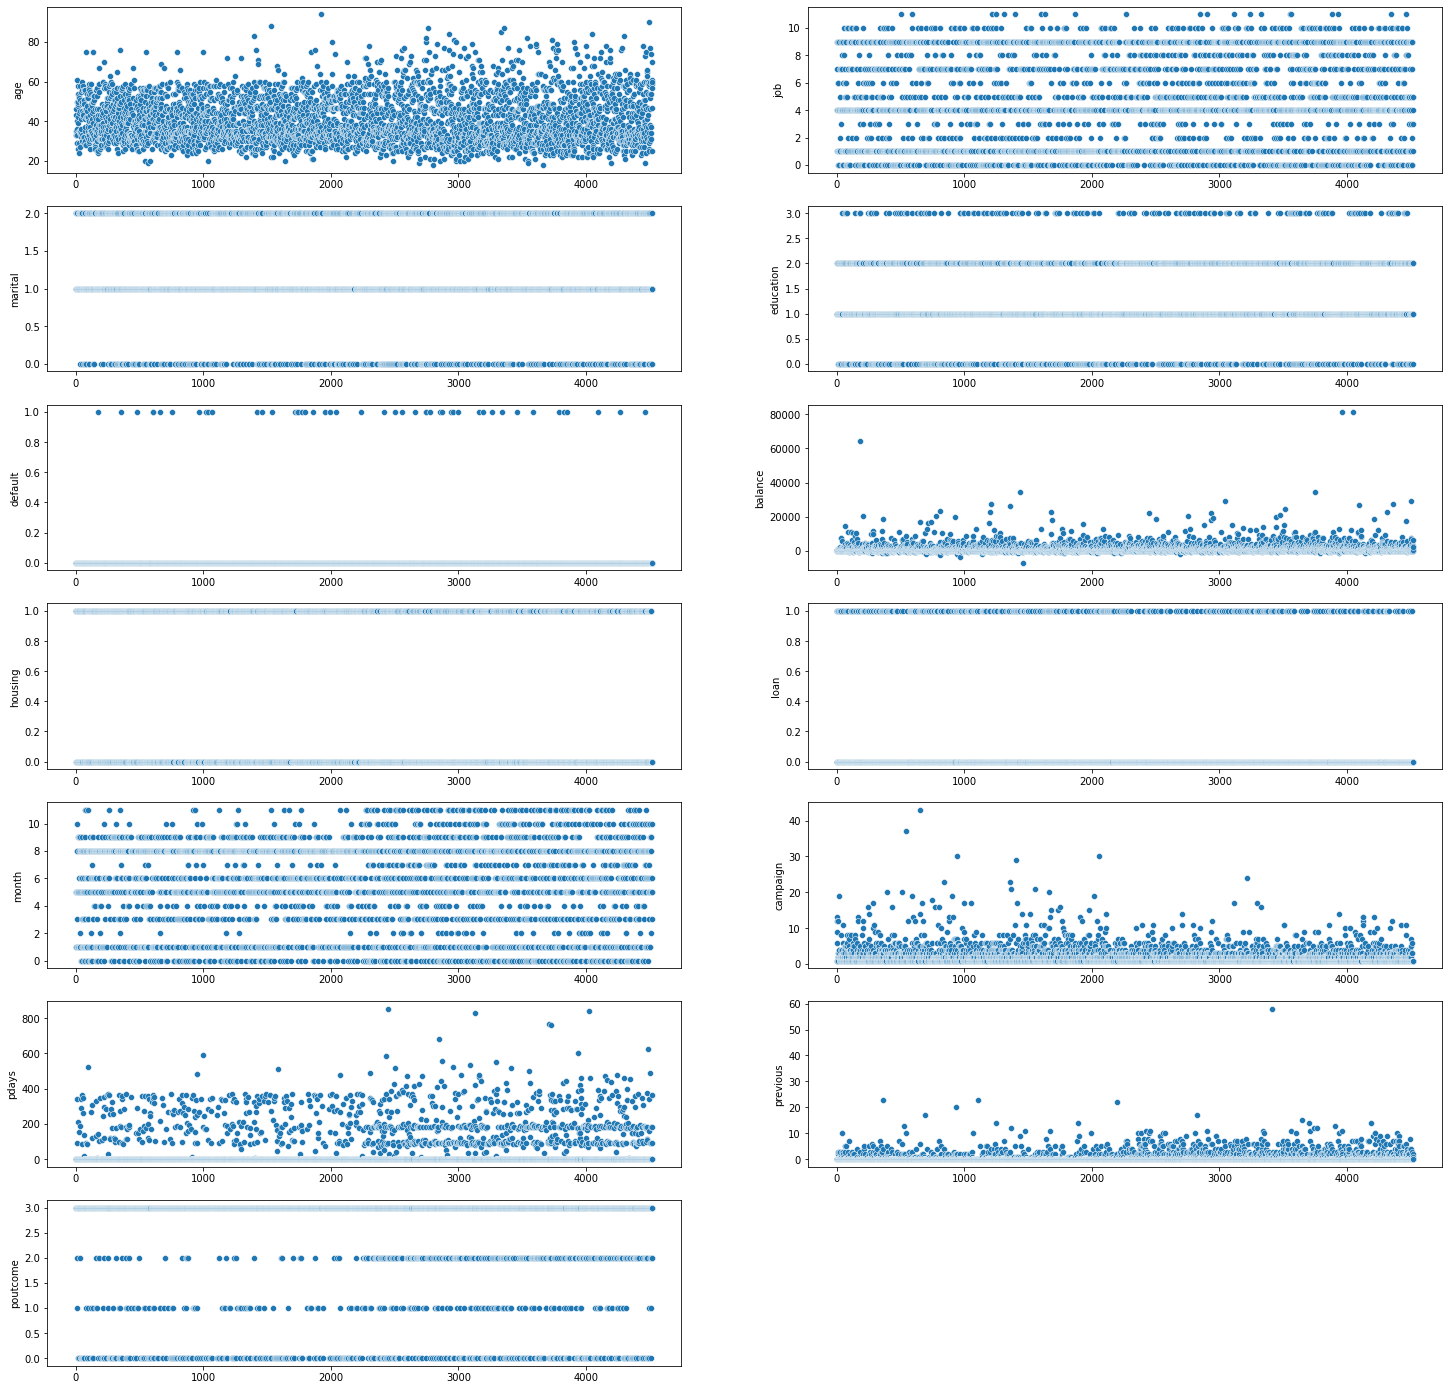

In [55]:
a=['age', 'job', 'marital', 'education', 'default', 'balance', 'housing','loan', 'month', 'campaign', 'pdays', 'previous', 'poutcome']
q=0
plt.figure(figsize=(25,25))
for i in a:
    q=1+q
    plt.subplot(7,2,q)
    sns.scatterplot(x=Ndf.index, y=Ndf[i])

Los datos suministrados como se dijo al principio del cuadernillo son de una campaña de marketing de una institución bancaria, por ende se contacta a un gran numero de personas mayores de edad y cada una posee caracteristicas muy diferentes, lo que genera la alta variabilidad en los datos y el alto error al momento de imputar. Es por esta razon que se decide disminuir el rango en el cual varian los atributos a traves de la  ***ESTANDARIZACION.***

#### Discretización

Los atributos que se van a estandarizar son: ***Age, Balance, Campaign, Pdays, Previous, Poutcome.*** ya que a partir de los graficos de dispersión reaizados anteriomente se observa alta variabilidad en estos atributos.

In [56]:
e=['age', 'balance', 'campaign', 'pdays', 'previous', 'poutcome']
scaler=StandardScaler()
scaler=scaler.fit(Ndf[e])
estandarizado=scaler.transform(Ndf[e])
estandarizado=pd.DataFrame(estandarizado,columns=e)

In [57]:
for i in e:
    Ndf[i]=estandarizado[i].copy()

In [58]:
Ndf.head()

,age,job,marital,education,default,balance,housing,loan,month,campaign,pdays,previous,poutcome,y
0,-0.522966,9.0,2.0,2.0,0.0,-0.294517,0.0,0.0,1.0,3.984493,-0.473929,-0.365748,0.518781,0
1,0.398516,NaN,NaN,NaN,0.0,-0.429345,1.0,0.0,1.0,1.324922,-0.473929,-0.365748,0.518781,0
2,-0.690508,4.0,2.0,1.0,0.0,-0.391397,1.0,1.0,NaN,-0.574772,-0.473929,-0.365748,0.518781,0
3,-0.690508,1.0,1.0,1.0,NaN,-0.460105,1.0,1.0,5.0,3.604555,-0.473929,-0.365748,0.518781,0
4,0.147202,NaN,1.0,1.0,0.0,-0.254845,1.0,0.0,5.0,-0.574772,-0.473929,-0.365748,0.518781,0


In [59]:
matriz=Ndf.to_numpy()

 ##### imputación por la media:

In [60]:
imputer=SimpleImputer(missing_values=np.nan,strategy='mean')
t1=imputer.fit_transform(matriz)
impmedia=pd.DataFrame(data=t1,columns=Ndf.columns)

Se verifica que se haya realizado la imputación correctamente:

In [61]:
impmedia.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

 ##### imputación por la mediana:

In [62]:
imputer=SimpleImputer(missing_values=np.nan,strategy='median')
t2=imputer.fit_transform(matriz)
impmediana=pd.DataFrame(data=t2,columns=Ndf.columns)

Se verifica que se haya realizado la imputación correctamente:

In [63]:
impmediana.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

 ##### imputación por la moda:

In [64]:
imputer=SimpleImputer(missing_values=np.nan,strategy='most_frequent')
t3=imputer.fit_transform(matriz)
impmoda=pd.DataFrame(data=t3,columns=Ndf.columns)

Se verifica que se haya realizado la imputación correctamente:

In [65]:
impmoda.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

##### KNN con 3 vecinos cercanos:

In [66]:
knn= KNNImputer(n_neighbors=3)
col=Ndf.columns
knn.fit(Ndf[col])
impKNN3=pd.DataFrame(knn.transform(Ndf[col]))
impKNN3.columns=col

Se verifica que se haya realizado la imputación correctamente:

In [67]:
impKNN3.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

##### KNN con 10 vecinos cercanos:

In [68]:
knn= KNNImputer(n_neighbors=10)
col=Ndf.columns
knn.fit(Ndf[col])
impKNN10=pd.DataFrame(knn.transform(Ndf[col]))
impKNN10.columns=col

Se verifica que se haya realizado la imputación correctamente:

In [69]:
impKNN10.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

##### KNN con 15 vecinos cercanos:

In [70]:
knn= KNNImputer(n_neighbors=15)
col=Ndf.columns
knn.fit(Ndf[col])
impKNN15=pd.DataFrame(knn.transform(Ndf[col]))
impKNN15.columns=col

Se verifica que se haya realizado la imputación correctamente:

In [71]:
impKNN15.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

##### Evaluación de los metodos de imputación:

El criterio de decisión será el menor MSE calculado, sin embargo hay que recordar que cada uno de los data set imputados posee valores numericos y el data set con los valores verdaderos (datos) aún posee valores categoricos, por ende se procede a discretizar este último para no generar errores al momento del calculo del MSE:

In [72]:
original=datos.copy()
diccionarios=[djob,dmarital,deducation,dmonth,dpoutcome]
categorical=['job','marital','education','month','poutcome']
for i in categorical:
    for j in diccionarios:    
        original[i]=original[i].replace(j)

In [73]:
m=['default','housing','loan','y']
for i in m:
    original[i]=original[i].replace('yes',1)
    original[i]=original[i].replace('no',0)      

In [74]:
## Se guarda este data set, servirá para el momento del clustering
dfc=original.copy()

Recordando que antes de realizar las imputacioens se realizó una estandarización al data set **Ndf**, se debe estandarizar el data set **Original** porque de lo contrario, los MSE darían ilogicos ya que se estarian comparando escalas diferentes para algunos atributos:

In [75]:
scaler=StandardScaler()
scaler=scaler.fit(original[e])
estandarizado2=scaler.transform(original[e])
estandarizado2=pd.DataFrame(estandarizado2,columns=e)

In [76]:
for i in e:
    original[i]=estandarizado2[i].copy()

Se procede a calcular los MSE para cada data set imputado:

In [77]:
a=['age', 'job', 'marital', 'education', 'default', 'balance', 'housing','loan', 'month', 'campaign', 'pdays', 'previous', 'poutcome']
d=[impmedia,impmediana,impmoda,impKNN3,impKNN10,impKNN15]
MSE=pd.DataFrame(index=a)
l1=[]
s=0
for i in d:
    for j in a:
        y_true=original[j]
        y_pred=i[j]
        l1.append(mean_squared_error(y_true, y_pred))
    s=s+1
    if s==1:
        name='Valores MSE media'
    elif s==2:
        name='Valores MSE mediana'
    elif s==3:
        name='Valores MSE moda'
    elif s==4:
        name='valores MSE KNN3'
    elif s==5:
        name='Valores MSE KNN10'
    else:
        name='Valores MSE KNN15'
    MSE[name]=l1
    l1.clear()
    name=''

In [78]:
MSE

,Valores MSE media,Valores MSE mediana,Valores MSE moda,valores MSE KNN3,Valores MSE KNN10,Valores MSE KNN15
age,0.115520,0.122386,0.178668,0.084082,0.068331,0.069624
job,1.181696,1.196816,1.196816,1.465404,1.228751,1.192826
marital,0.039597,0.042680,0.042680,0.041992,0.035615,0.035330
education,3.093477,3.120522,3.120522,3.085066,3.074016,3.078153
default,0.002821,0.002875,0.002875,0.003071,0.002937,0.002886
balance,0.066907,0.073387,0.084592,0.082538,0.074036,0.069779
housing,0.027144,0.049757,0.049757,0.026905,0.021703,0.020630
loan,0.011285,0.012826,0.012826,0.014866,0.012596,0.011752
month,1.155896,1.167846,1.804732,1.352130,1.172227,1.093766
campaign,0.088378,0.091685,0.122233,0.118797,0.091652,0.088051


Valores MSE media      0.480232
Valores MSE mediana    0.493530
Valores MSE moda       0.550062
valores MSE KNN3       0.505967
Valores MSE KNN10      0.466649
Valores MSE KNN15      0.457048
dtype: float64

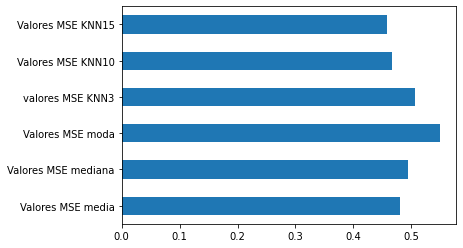

In [79]:
MSE.mean().plot.barh()
MSE.mean()

La mejor imputación fue realizada por KNN con 15 vecinos cercanos, por ende se escoge este data set porque es el que tiene menor MSE

#### 4. Clasificación Supervisada

Para la construccion de los diferentes modelos se extrae el 70% del DataSet aleatoriamente.

In [80]:
X= impKNN15 [['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'month', 'campaign', 'pdays', 'previous', 'poutcome']]
Y= impKNN15['y']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, test_size=0.3, random_state = 1)

#### ***- Decision Tree***

En la siguiente linea de codigo se construye el arbol de decision que permitira hacer la clasificacion supervisada o prediccion. Dicho arbol se realizo bajo el criterio entropia y gini para definir la ganancia de información y determinar los niveles del arbol.

In [81]:
arbolE = DecisionTreeClassifier(criterion = 'entropy' ,random_state=1)
arbolE = arbolE.fit(Xtrain,Ytrain)

In [82]:
arbolG = DecisionTreeClassifier(criterion = 'gini' ,random_state=1)
arbolG = arbolG.fit(Xtrain,Ytrain)

#### ***- Random Forest***

En la siguiente linea de codigo se construye el Random Forests la clasificación supervisada o prediccion, la cual sera evaluada más adelante. 

"En general, cuantos más árboles utilice, mejor sera la precision del random forests. Sin embargo, la mejora disminuye a medida que aumenta el número de árboles, es decir, en un cierto punto, el beneficio en el rendimiento de la predicción al tener más árboles será menor que el costo en tiempo de cálculo de tener estos árboles adicionales"

El numero de arboles tambien esta directamente relacionado con el numero de registros del DataSet, para este caso se tiene gran cantidad de registros por lo que se espera necesitar de un gran numero de arboles para obtener una alta precision en la construccion del modelo.

Tomado de:  Ramon, Jan. (2013). Re: How to determine the number of trees to be generated in Random Forest algorithm?. Retrieved from: https://www.researchgate.net/post/How_to_determine_the_number_of_trees_to_be_generated_in_Random_Forest_algorithm/52b6a9eed4c118a6208b4855/citation/download. 

In [83]:
NumberArboles= [100,200,300,400,500,600,700,800,900,1000,2000]
arboless=[]
for i in NumberArboles :
    Numero_de_arboles = i
    bosque=RandomForestClassifier(n_estimators=Numero_de_arboles, random_state=1)
    bosque.fit(Xtrain,Ytrain)
    arboless.append(bosque)

En la anterior linea de codigo se contruyó el random forest partiendo de 100 arboles, luego a 200, luego 300 y asi hasta 1000, luego se construyo el ultimo bosque con 2000 arboles, esto con el fin de calcular la precision de cada random forest y ver que numero de arboles era el más apropiado.

#### ***- ADA Boosted Trees***

El algoritmo AdaBoost consiste en usar árboles de decisión de un nivel, estos arboles son debiles para realizar una prediccion correcta, pero la precision se va mejorando proporcional al numero de iteraciones del AdaBoost. El modelo que construye este algoritmo se realiza a traves de iteraciones donde en cada iteración se intenta corregir las predicciones hechas por el modelo anterior en la secuencia.

Los principales parametros del AdaBoost son *Base_Estimator* y *n_estimators*, el primero mencionado es la profundidad del árbol de decision, lo cual ayudaria desde la primera iteración a construir un mejor modelo. Y el segundo parametro es el numero de iteraciones que realiza el algoritmo, como se menciono anteriormente en cada iteracion, el algoritmo busca corregir las prediccion hechas por el modelo anterior en la secuencia.

Existe un problema con estos dos parametros y es que se puede pensar que al tener mayor profundidad en los arboles de decision y tener muchas iteraciones es sinonimo de un modelo con alta precision en la prediccion, pero esto no es cierto, lo que se genera con esto es un sobre ajuste o mas conocido como **overfitting** del modelo, lo cual se ajusta muy bien a los datos con los que se ha entrenado el modelo, pero NO es conveniente debido a que ante nuevos datos tendra una precision baja. 

Por esta razón es que a continuación solo se hacen 90 iteraciones con *base_Estimator = 1*, se variaron mucho estos parametros para tratar de ver con cual se tenia mayor precision.

In [84]:
adaBT = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=90, random_state=1)
adaBT.fit(Xtrain, Ytrain)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=90, random_state=1)

#### 5. Evaluación

La evaluación se va a realizar calculando la **precision** de cada modelo construido por los diferentes tecnicas y tambien mediante otra metrica llamada **AUC** que es el area bajo la curva ROC (curva de característica operativa del recepto), dicha curva es un gráfico que muestra el rendimiento de un modelo de clasificación en todos los umbrales de clasificación. Esta curva representa dos parámetros; la tasa de verdaderos positivos y la tasa de falsos positivos.

##### - Decision Tree

Como se menciono anteriormente, se realizaron dos arboles de decision, uno bajo el criterio gini y el otro bajo la entropia. Esto con el fin de saber con que criterio se obtiene una mayor precision del modelo. Tener en cuenta que estos dos criterios son dos formas diferentes para calcular la ganancia de información que definen los diferentes niveles del arbol.

   - **Precision** 

In [85]:
Y_prediccion = arbolE.predict(Xtest)
metrics.accuracy_score(Ytest,Y_prediccion)

0.6241709653647752

La precision del arbol de decision bajo el criterio de la entropia es del **62%**

In [86]:
Y_prediccion = arbolG.predict(Xtest)
metrics.accuracy_score(Ytest,Y_prediccion)

0.627855563743552

La precision del arbol de decision bajo el criterio de gini es del **61.4%**

   - **AUC**

In [87]:
Y_prediccion = arbolE.predict(Xtest)
dtAUC, dttAUC, umbral = metrics.roc_curve(Ytest, Y_prediccion)
metrics.auc(dtAUC,dttAUC)

0.6242826110568046

El area bajo la curva ROC o rendimiento del modelo es de **0.62**.

In [88]:
Y_prediccion = arbolG.predict(Xtest)
dtAUC, dttAUC, umbral = metrics.roc_curve(Ytest, Y_prediccion)
metrics.auc(dtAUC,dttAUC)

0.6278798740089062

El area bajo la curva ROC o rendimiento del modelo es de **0.6137**.

La entropia es el mejor criterio para la construccion del modelo ya que da una precision y un AUC mas alto, comparado con el criterio gini, esto no quiere decir que siempre se debe realizar el arbol de decision bajo este criterio, ya que ningun criterio es mejor que el otro, simplemente se ajusta mejor a este conjunto de datos. Vale recordar que la entropia y gini miden el ruido o la incertidumbre de los datos pero la miden de diferente manera.

Se decidio graficar la matriz de confusion la cual nos mostrara el numero de predicciones correctas que son los valores que se encuentran en la diagonal principal.

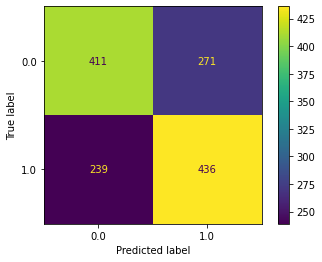

In [89]:
plot_confusion_matrix(arbolE, Xtest, Ytest)
plt.show()

##### - Random Forests

In [90]:
prec = []
for i in arboless :    
    Ypred = i.predict(Xtest)
    prec.append(metrics.accuracy_score(Ytest, Ypred))
tabla = pd.DataFrame(prec , index= ['100 arboles', '200 arboles', '300 arboles', '400 arboles', '500 arboles', '600 arboles', '700 arboles', '800 arboles', '900 arboles', '1000 arboles', '2000 arboles'], columns =['Precision'])
tabla

,Precision
100 arboles,0.714075
200 arboles,0.721444
300 arboles,0.726603
400 arboles,0.725866
500 arboles,0.720707
600 arboles,0.721444
700 arboles,0.717760
800 arboles,0.718497
900 arboles,0.714812
1000 arboles,0.714075


Como se creo varios random forest con diferente numero de arboles, se calculo la precision de cada uno. El Random Forest con el que nos vamos a quedar es el que tiene 300 arboles ya que tiene la mayor precision. (**72.5%**)

   - **AUC**

In [91]:
Y_prediccion = arboless[2].predict(Xtest)
dtAUC, dttAUC, umbral = metrics.roc_curve(Ytest, Y_prediccion)
metrics.auc(dtAUC,dttAUC)

0.7263864450961225

El area bajo la curva ROC o rendimiento del modelo es de **0.72**.

A continuación se muestra la matriz de confusion donde las predicciones correctas se muestran en la diagonal principal.

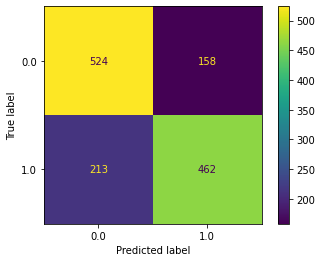

In [92]:
plot_confusion_matrix(arboless[2], Xtest, Ytest)
plt.show()

##### - ADA Boosted Trees

Como se menciono al momento de crear el modelo, se variaron los dos parametros hasta obtener la mayor precision en la prediccion.

  - **Precision**

In [93]:
Y_prediccion = adaBT.predict(Xtest)
metrics.accuracy_score(Ytest,Y_prediccion)

0.7008106116433309

La precision maxima obtenida es de **70.67%**.

 - **AUC**

In [94]:
Y_prediccion = adaBT.predict(Xtest)
btAUC, bttAUC, umbral = metrics.roc_curve(Ytest, Y_prediccion)
metrics.auc(btAUC,bttAUC)

0.700612577386771

El area bajo la curva ROC o rendimiento del modelo es del **0.7065**

A continuación se muestra su matriz de confusion.

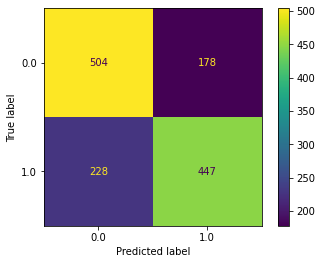

In [95]:
plot_confusion_matrix(adaBT, Xtest, Ytest)
plt.show()

Teniendo en cuenta la evaluación de los diferentes modelos, la mayor precision y el mayor rendimiento se genera con el modelo construido mediante la tecnica de clasificación **RANDOM FOREST**, por ende dicha tecnica es la mejor para este conjunto de datos, con una precision de **72.5%** nos permite predecir si un cliente suscribira o no un deposito a plazo bancario.

### Atributos más importantes

La grafica que se muestra a continuación permite observar el porcentaje de importancia de cada atributo dentro del clasificador random forest con 300 arboles, teniendo en cuenta que este fue el mejor clasificador al obtener una precisión del 72,5% y un AUC del 72,6%. Se observa que los 5 atributos más importantes fueron: **balance, age, month, campaign y job**

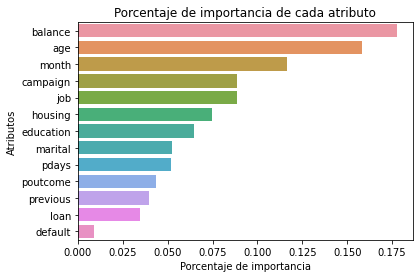

In [96]:
## Codigo tomado de los cuadernillos compartidos por el profesor wilmer garzón
atributos_imp = pd.Series(arboless[2].feature_importances_,index=Xtrain.columns).sort_values(ascending=False)
sns.barplot(x=atributos_imp, y=atributos_imp.index)
plt.xlabel('Porcentaje de importancia')
plt.ylabel('Atributos')
plt.title("Porcentaje de importancia de cada atributo")
plt.show()

Una vez conocidos cuales son los atributos más importantes para el clasificador, se procede a examinar cuales valores de cada atributo están relacionados con la clase de interés (yes) con el fin de darle una recomendación al banco en cuanto a las caracteristicas de la persona que sería más propensa a adquirir un deposito a término fijo:

A continuación se realiza un histograma de frecuencia para el atributo **Balance** filtrando solo aquellos registros cuya clase fue **yes**, se observa que las personas cuyo saldo promedio anual sea menor a 20000 euros son más propensos a adquirir un deposito a término fijo

<AxesSubplot:ylabel='Frequency'>

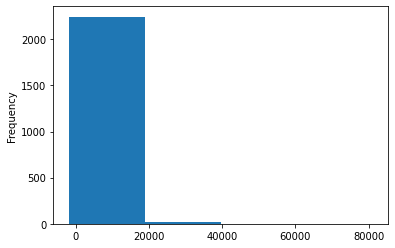

In [97]:
datos[datos['y']=='yes']['balance'].plot(kind='hist',bins=4)

A continuación se presenta un histograma de frecuencia en donde se observa que las personas entre 24 y 40 años son más propensas a adquirir un deposito a término fijo

<AxesSubplot:ylabel='Frequency'>

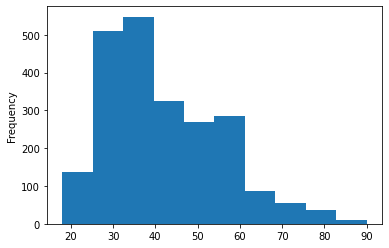

In [98]:
datos[datos['y']=='yes']['age'].plot(kind='hist',bins=10)


 A continuación se presenta un gráfico dinámico que representa el porcentaje de clientes que adquirireon un deposito a término fijo según el mes en que fueron contactados, se observa que los mejores meses para realizar esta campaña son:diciembre, marzo, septiembre,octubre porque presentan mayor porcentaje de registros con clase **yes**

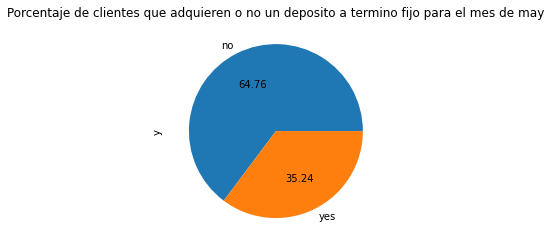

interactive(children=(Dropdown(description='mes', options=('may', 'jul', 'aug', 'jun', 'nov', 'apr', 'feb', 'j…

<function __main__.g(mes)>

In [99]:
meses=['may','jul','aug','jun','nov','apr','feb','jan','oct','sep','mar','dec']
def g(mes):
    datos[datos['month']==mes].groupby('y')['y'].count().plot(kind='pie',autopct='%.2f',title='Porcentaje de clientes que adquieren o no un deposito a termino fijo para el mes de '+mes)
interact(g,mes=meses)

De la gráfica que se muestra a continuación se observa que se debrían hacer entre 1 y 4 contactos previamente con el cliente  para que adquiera un desposito a término fijo

<AxesSubplot:ylabel='Frequency'>

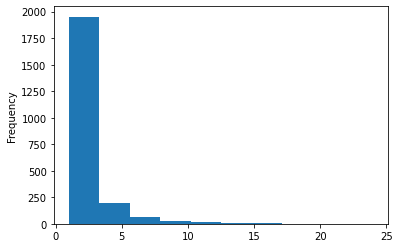

In [100]:
datos[datos['y']=='yes']['campaign'].plot(kind='hist',bins=10)

En el siguiente gráfico dinámico se presenta el porcentaje de registros que adquirieron o no un deposito a término fijo según el tipo de trabajo, se encontro que personas cuyo trabajo sea: unknown,unemployed,management,student,self-employed y retired, son más propensas a invertir en un deposito a término fijo.

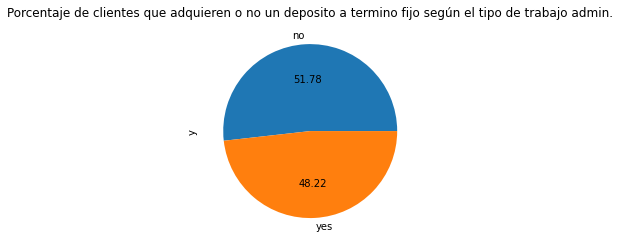

interactive(children=(Dropdown(description='Trabajo', options=('admin.', 'unknown', 'unemployed', 'management'…

<function __main__.gj(Trabajo)>

In [101]:
job=["admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services"] 
def gj(Trabajo):
    datos[datos['job']==Trabajo].groupby('y')['y'].count().plot(kind='pie',autopct='%.2f',title='Porcentaje de clientes que adquieren o no un deposito a termino fijo según el tipo de trabajo '+Trabajo)
interact(gj,Trabajo=job)

### Conclusión

Se logró encontrar el mejor clasificador el cual fue random forest porque tenia la mayor precisión respecto a los demás clasificadores y porque logra predecir de una mejor manera la clase de interés (yes).Teniendo en cuenta que realizar la campaña de marketing mediante llamadas telefonicas implica programar personas en un call center para realizar estas llamadas, este algoritmo permite optimizar el recurso humano, ya que antes de iniciar la campaña se podría utilizar este algoritmo para seleccionar aquellos clientes potenciales y de esta manera utilizar menos personal en el call center ya que entre más clientes se deban llamar se necesitarian más personas en el call center, si se utiliza esta herramienta se lograría evitar perder tiempo con persons que no invertirian en un deposito a término fijo.

De igual manera se encontró que personas cuyo trabajo sea **unknown,unemployed,management,student,self-employed y retired**, que se encuentren entre los **24 y 40 años** de edad y que su saldo promedio anual sea menor a **20000 euros** son clientes potenciales para adquirir un deposito a término fijo. Se recomienda a la empresa contactar al cliente entre 1 y 4 veces, tambien se espera que la campaña tenga más exito en los meses de **diciembre, marzo, septiembre y octubre**